# Exact variance component test for SNP set anlaysis

### Check version of Julia

In [2]:
versioninfo()

Julia Version 0.6.4
Commit 9d11f62bcb (2018-07-09 19:09 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i7-7920HQ CPU @ 3.10GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell MAX_THREADS=16)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, broadwell)


## Install packages if first time using them

In [2]:
#Pkg.clone("https://github.com/OpenMendel/SnpArrays.jl.git")
#Pkg.clone("git@github.com:jinjinzhou/VarianceComponentTest.jl.git")
#Pkg.add("Query")

INFO: Cloning VarianceComponentTest from git@github.com:jinjinzhou/VarianceComponentTest.jl.git
INFO: Computing changes...
INFO: Removing LaTeXStrings v1.0.0
INFO: Removing PyCall v1.17.1
INFO: Removing PyPlot v2.6.0
INFO: Package database updated


## Load required packages

In [3]:
using SnpArrays
using CSV
using DataFrames, Query
using Distributions
#using StatPlots
using VarianceComponentTest

## Annotation file
- Gene location annotation from http://uswest.ensembl.org/biomart/martview/e292ba28e6325bf11d6b1449b56ba690
- SNP annotation can be done by [SnpEff](http://snpeff.sourceforge.net/download.html), [Manual](http://snpeff.sourceforge.net/SnpEff_manual.html)

In [4]:
gene = CSV.read("chr19_chr20_gene_start_end.txt")

,Gene name,Gene end (bp),Gene start (bp),Chromosome/scaffold name
1,WASH5P,71626,60951,19
2,AC008993.1,69178,68403,19
3,AC008993.2,69972,69167,19
4,AC008993.3,72718,71778,19
5,MIR1302-11,72110,71973,19
6,FAM138F,77686,76163,19
7,OR4G3P,94974,94062,19
8,OR4G1P,106077,99175,19
9,OR4F17,117102,107104,19
10,WBP1LP11,145812,145485,19


In [54]:
## Number of genes on chromosome 19
gene = gene[gene[:,4].==19,:]
genes = size(gene,1)
#geneNames = unique(gene[gene[:,4].==19,1])
#size(geneNames,1)

2959

## Read in plink format genotype files

In [7]:
plinkFile = "SNP_29a"
## parse data from files
plinkBedfile = string(plinkFile, ".bed");
plinkBimfile = string(plinkFile, ".bim");
plinkFamfile = string(plinkFile, ".fam");

SNP_29a = SnpData("SNP_29a");

INFO: v1.0 BED file detected


In [8]:
# BIM file: chr, rs#, morgan, bp position, allele1, allele2
bimdata = readdlm(plinkBimfile, String);
chrID = bimdata[:, 1];
snpID = bimdata[:, 2];
nSNP = length(snpID);
snpPos = bimdata[:, 4];

# FAM file: fam ID, ind ID, father ID, mother ID, sex, phenotype
famdata = readdlm(plinkFamfile);
nPer = length(famdata[:, 1]);
nSNP

253141

## Extract phenotype and covariates from `.fam` file
- Note that one can load phenotype file in `plink` format

In [48]:
fam = readcsv(plinkFamfile, Any; header = false)
y = convert(Vector{Float64}, fam[:, 7])
#Trait2 = convert(Vector{Float64}, pedLMM[:, 8])
#Y = [Trait1 Trait2]
sex = map(x -> strip(x) == "F"? 1.0 : 0.0,  fam[:, 5])
# covariates
X = [ones(size(sex,1)) sex];

212×2 Array{Float64,2}:
 1.0  1.0
 1.0  1.0
 1.0  0.0
 1.0  0.0
 1.0  1.0
 1.0  1.0
 1.0  0.0
 1.0  0.0
 1.0  1.0
 1.0  0.0
 1.0  1.0
 1.0  0.0
 1.0  1.0
 ⋮       
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  1.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0

## Option `pvalueComputing`

Chi squared approximation is recommended (default). 

**Note**: Option `pvalueComputing` is only for eLRT and eRLRT. For eScore, it employs the method of inverting characteristics function to compute the p-value.

## Option `nNullSimPts`

If Monte Carlo method is chosen, generate 10,000 (`nNullSimPts`) replicate for calculation of p-values.

If Chi squared approximation method is chosen, you can generate more replicates (default value is 1,000,000) to have a better estimator of point mass at 0.

## Loop over genes

In [110]:
#genes = 100;
nNullSimPts = 1000000;
nPtsChi2 = 500;
pvalELRT = Array{Float64}(genes)
pvalERLRT = Array{Float64}(genes)
pvalEscore = Array{Float64}(genes)

@time for i = 1:genes
#i=1
    snpset_index = (SNP_29a.basepairs .< gene[i,2]) .&  (SNP_29a.basepairs .> gene[i,3])
    if(sum(snpset_index)==0) 
        pvalELRT[i] = NaN
        pvalERLRT[i] = NaN
        pvalEscore[i] = NaN
        continue
    else
        G = convert(Matrix{Float64}, SNP_29a.snpmatrix[:, snpset_index])
        # get rid of mono-snp
        maf = sum(G,1)/(2*nPer);
        G = G[:,find(x -> maf[x] > 0, 1:size(G,2))];
        windowSize = size(G,2);
    
        if(windowSize > 5 && windowSize < 50)
            (b, vc0, vc1, pvalELRT[i]) =
                vctest(y, X, G, 
                   tests = "eLRT", 
                   Vform = "half", 
                    nPtsChi2 = nPtsChi2,
                    windowSize = windowSize,
                    pvalueComputings = "chi2",
                    #pvalueComputings = "MonteCarlo", 
                    nNullSimPts = nNullSimPts);     
        
            (b, vc0, vc1, pvalERLRT[i]) =
                vctest(y, X, G, 
                tests = "eRLRT", 
                Vform = "half",
                nPtsChi2 = nPtsChi2,
                windowSize = windowSize,
                pvalueComputings = "chi2",
                #pvalueComputings = "MonteCarlo", 
                nNullSimPts = nNullSimPts);
        
            (b, vc0, vc1, pvalEscore[i]) =
                vctest(y, X, G, tests = "eScore", 
                    Vform = "half",
                   windowSize = windowSize)
            
            println("finished $i")
        else
            pvalELRT[i] = NaN
            pvalERLRT[i] = NaN
            pvalEscore[i] = NaN
        end
    end    
end

finished 9
finished 25
finished 26
finished 35
finished 41
finished 43
finished 44
finished 46
finished 50
finished 55
finished 56
finished 57
finished 58
finished 62
finished 65
finished 67
finished 70
finished 77
finished 81
finished 83
finished 84
finished 85
finished 86
finished 87
finished 88
finished 95
finished 96
finished 97
finished 105
finished 106
finished 109
finished 114
finished 124
finished 126
finished 130
finished 132
finished 134
finished 136
finished 137
finished 142
finished 145
finished 146
finished 150
finished 153
finished 155
finished 157
finished 160
finished 163
finished 172
finished 174
finished 176
finished 177
finished 182
finished 189
finished 203
finished 207
finished 209
finished 213
finished 218
finished 219
finished 221
finished 224
finished 227
finished 228
finished 229
finished 230
finished 237
finished 240
finished 248
finished 257
finished 259
finished 265
finished 269
finished 270
finished 276
finished 283
finished 284
finished 286
finished 297
fi

finished 1884
finished 1885
finished 1886
finished 1887
finished 1889
finished 1892
finished 1893
finished 1896
finished 1898
finished 1901
finished 1902
finished 1903
finished 1906
finished 1908
finished 1913
finished 1915
finished 1918
finished 1925
finished 1928
finished 1932
finished 1933
finished 1940
finished 1943
finished 1948
finished 1949
finished 1952
finished 1961
finished 1964
finished 1975
finished 1976
finished 1978
finished 1984
finished 1986
finished 1988
finished 1989
finished 1990
finished 1991
finished 1992
finished 1993
finished 1994
finished 1995
finished 2000
finished 2006
finished 2007
finished 2008
finished 2018
finished 2021
finished 2022
finished 2023
finished 2029
finished 2034
finished 2037
finished 2039
finished 2040
finished 2041
finished 2042
finished 2043
finished 2044
finished 2048
finished 2049
finished 2050
finished 2051
finished 2055
finished 2056
finished 2059
finished 2060
finished 2064
finished 2066
finished 2078
finished 2079
finished 2080
finish

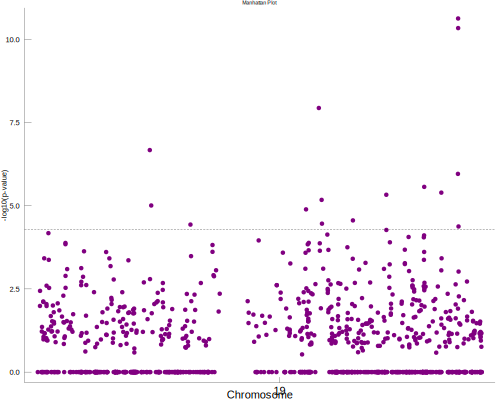

In [116]:
using Plots                             # From package Plots.
gr(size=(2000,1600))
index = .!isnan.(pvalELRT)
# testrun was set up early 
#plot_frame = DataFrame(AdjBasepairs = snpLMM[1:testrun,4], 
#    Chromosome = snpLMM[1:testrun,1], 
#    NegativeLogPvalue = -log10.(pvalue[1:testrun]))

# for full datasets
plot_frame = DataFrame(AdjBasepairs = floor.((gene[index,2].+gene[index,3])/2), 
    Chromosome = gene[index,4], 
    NegativeLogPvalue = -log10.(pvalELRT[index]))

plt = scatter(plot_frame[:AdjBasepairs], plot_frame[:NegativeLogPvalue],
      group = plot_frame[:Chromosome],
      markersize = 10, markerstrokewidth = 0, color_palette = :rainbow)


xticks = by(plot_frame, :Chromosome,
        plot_frame -> mean(plot_frame[:AdjBasepairs]))
xaxis!(plt, xticks = (sort(xticks[:x1])[1:2:end], 
        xticks[1:2:size(xticks, 1),:Chromosome]),
      font(30))
xaxis!(plt, xlabel = "Chromosome")
#
# Add the y-axis information.
#
yaxis!(plt, ylabel = "-log10(p-value)",font(20))
#
# Use a grey grid and remove the legend.
#
plot!(plt, gridcolor = :lightgrey, legend = false)
#
# Add an overall title.
#
#Plots.scalefontsizes(5)
plot!(plt, title = "Manhattan Plot", window_title = "Manhattan Plot")
#
# Add a dashed horizontal line that indicates the Bonferonni threshold.
#
Plots.abline!(plt, 0, -log10(.05 / length(pvalELRT[index])), color = :black,
        line = :dash)


In [117]:
pvalELRT[index]

954-element Array{Float64,1}:
 1.0       
 0.0102817 
 0.00362027
 1.0       
 0.0601198 
 0.0439187 
 1.0       
 1.0       
 1.0       
 0.00755495
 0.00779372
 0.1038    
 0.0874936 
 ⋮         
 1.0       
 0.0908176 
 1.0       
 0.0620136 
 0.0850603 
 1.0       
 0.113135  
 0.173336  
 1.0       
 0.0677875 
 1.0       
 1.0       